# Trabajo Práctico Clasificación

## Integrantes:

* Augusto Kark
* Lucas Garcia

---
# Importamos librerias y creamos el dataframe

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer


data = load_breast_cancer()

df = pd.DataFrame(data=data.data, columns=data.feature_names)

df["diagnostico"] = data.target

---

# Limpiamos y entendemos el dataset

In [13]:
# Entendemos el dataset
df.info()
df.describe()
print(data.target_names)
print(data.target)

# Revisamos si hay valores duplicados
print(f"Cantidad de datos duplicados: {df.duplicated().sum()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

---
## Dividimos el dataset

### Explicacion:

> Utilizamos StratifiedKFold para mantener la proporción de clases en cada grupo de entrenamiento y prueba.

CV 1: Entrenamiento 1.69 C1/C0 | Test 1.65 C1/C0
CV 2: Entrenamiento 1.69 C1/C0 | Test 1.65 C1/C0
CV 3: Entrenamiento 1.68 C1/C0 | Test 1.71 C1/C0
CV 4: Entrenamiento 1.68 C1/C0 | Test 1.71 C1/C0
CV 5: Entrenamiento 1.68 C1/C0 | Test 1.69 C1/C0


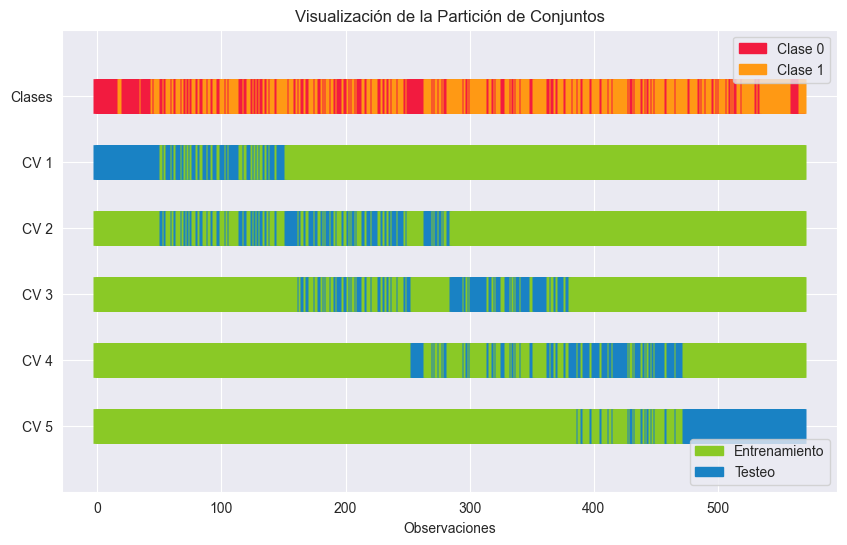

In [31]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

cmap_clases = ListedColormap(['#f21b3f', '#ff9914'])
cmap_train_test = ListedColormap(['#8ac926', '#1982c4'])

def visualize_split(classes, groups, splits):
    fig, ax = plt.subplots(figsize=(10, 6))
    espaciado = list(range(splits, 0, -1))

    # Graficar las clases
    ax.scatter(range(len(classes)), [splits + 1.0] * len(classes), c=classes, marker='_', lw=25, cmap=cmap_clases)
    legend1 = ax.legend([Patch(color=cmap_clases(0.0)), Patch(color=cmap_clases(1.0))], ['Clase 0', 'Clase 1'], loc='upper right')

    if splits == 1:
        ax.scatter(range(len(groups)), [splits] * len(groups), c=groups, marker='_', lw=25, cmap=cmap_train_test)
        ax.set(yticks=[splits, splits + 1.0], yticklabels=['Entrenamiento/Testeo', 'Clases'], xlabel="Observaciones")
        ax.legend([Patch(color=cmap_train_test(0.0)), Patch(color=cmap_train_test(1.0))], ['Entrenamiento', 'Testeo'], loc='lower right')
        ax.add_artist(legend1)

    elif splits == len(classes):
        for i in range(len(espaciado)):
            ax.scatter(range(len(groups[i])), [espaciado[i]] * len(groups[i]), c=groups[i], marker='_', lw=25, cmap=cmap_train_test)
        ax.legend([Patch(color=cmap_train_test(0.0)), Patch(color=cmap_train_test(1.0))], ['Entrenamiento', 'Testeo'], loc='lower right')
        ax.add_artist(legend1)
        if splits < 11:
            ticklabels = [f'CV {x}' for x in reversed(espaciado)]
            ticklabels.append('Clases')
            espaciado.append(splits + 1)
            ax.set(yticks=espaciado, yticklabels=ticklabels, xlabel="Observaciones")

    else:
        for i in range(len(espaciado)):
            ax.scatter(range(len(groups[i])), [espaciado[i]] * len(groups[i]), c=groups[i], marker='_', lw=25, cmap=cmap_train_test)
        ax.legend([Patch(color=cmap_train_test(0.0)), Patch(color=cmap_train_test(1.0))], ['Entrenamiento', 'Testeo'], loc='lower right')
        ax.add_artist(legend1)
        if splits < 11:
            ticklabels = [f'CV {x}' for x in reversed(espaciado)]
            ticklabels.append('Clases')
            espaciado.append(splits + 1)
            ax.set(ylim=[0, splits + 2], yticks=espaciado, yticklabels=ticklabels, xlabel="Observaciones")

    plt.title('Visualización de la Partición de Conjuntos')
    plt.show()

X = df.drop("diagnostico", axis=1)
y = df["diagnostico"]

# Escalamos los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

n_splits = 5

clases = y

skf = StratifiedKFold(n_splits=n_splits)

grupos = []
folds_indices = []

# Datos de la partición
nro = 1
for train_index, test_index in skf.split(X_scaled, y):
    grupo = np.zeros(y.shape)
    for i in range(len(grupo)):
        if i in train_index:
            grupo[i] = 0
        else:
            grupo[i] = 1

    grupos.append(grupo)
    
    folds_indices.append((train_index, test_index))

    train_C0 = 0
    train_C1 = 0
    test_C0 = 0
    test_C1 = 0

    for j in range(len(grupo)):  # recorro la información de grupo de entrenamiento/test
        if grupo[j] == 0 and clases[j] == 0:
            train_C0 += 1
        if grupo[j] == 0 and clases[j] == 1:
            train_C1 += 1
        if grupo[j] == 1 and clases[j] == 0:
            test_C0 += 1
        if grupo[j] == 1 and clases[j] == 1:
            test_C1 += 1

    print('CV %d: Entrenamiento %.2f C1/C0 | Test %.2f C1/C0' % (nro, train_C1 / train_C0, test_C1 / test_C0))
    nro += 1

visualize_split(clases, grupos, n_splits)

---
# Ajuste
## Revisamos la distribución de clases en el conjunto de datos

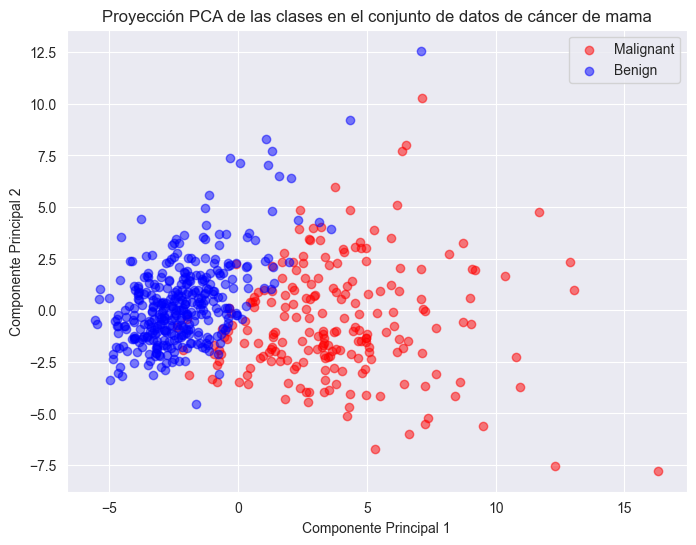

In [28]:
# Importar las bibliotecas necesarias
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler

# Cargar el conjunto de datos de cáncer de mama
data = load_breast_cancer()
X = data.data
y = data.target

# Escalar los datos para que tengan media 0 y varianza 1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar PCA para reducir los datos a 2 componentes principales
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Crear un gráfico de dispersión (scatter plot)
plt.figure(figsize=(8, 6))
colors = ['red', 'blue']
labels = ['Malignant', 'Benign']

for i in range(2):
    plt.scatter(X_pca[y == i, 0], X_pca[y == i, 1], c=colors[i], label=labels[i], alpha=0.5)

# Añadir etiquetas y leyenda
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Proyección PCA de las clases en el conjunto de datos de cáncer de mama')
plt.legend()
plt.grid(True)
plt.show()


## Al ser lineal elegimos LDA

In [34]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Definir el modelo LDA
lda = LinearDiscriminantAnalysis()

# Lista para almacenar los modelos entrenados
trained_models = []

# Entrenar el modelo en cada fold
for train_index, test_index in folds_indices:
    # Dividir los datos en entrenamiento y prueba usando los índices generados
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Entrenar el modelo LDA
    lda.fit(X_train, y_train)

    # Almacenar el modelo entrenado
    trained_models.append((lda, test_index))

---
# Métricas

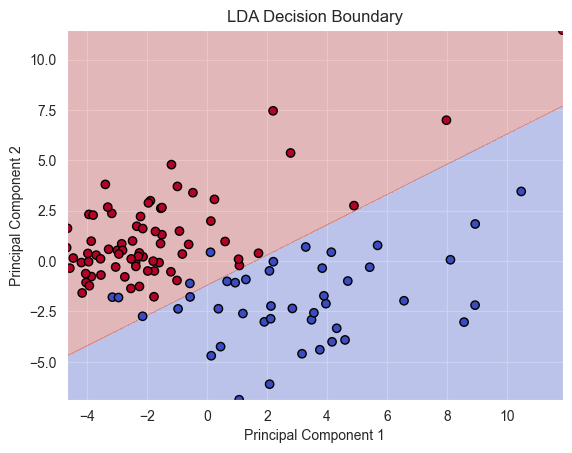

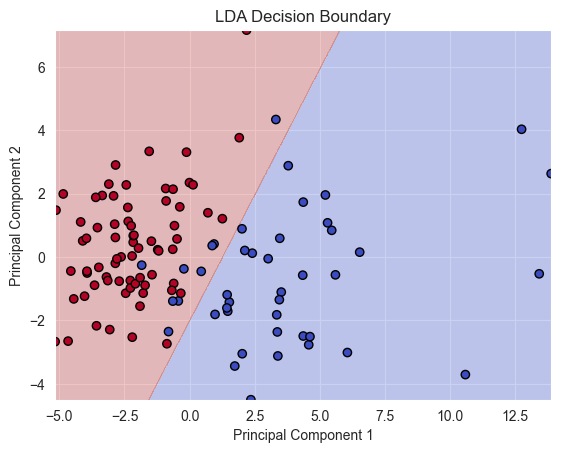

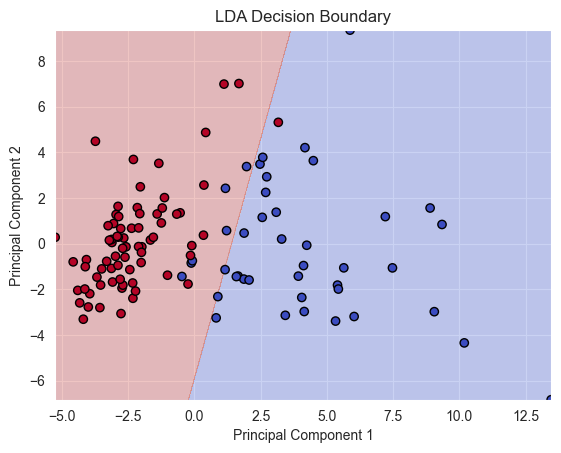

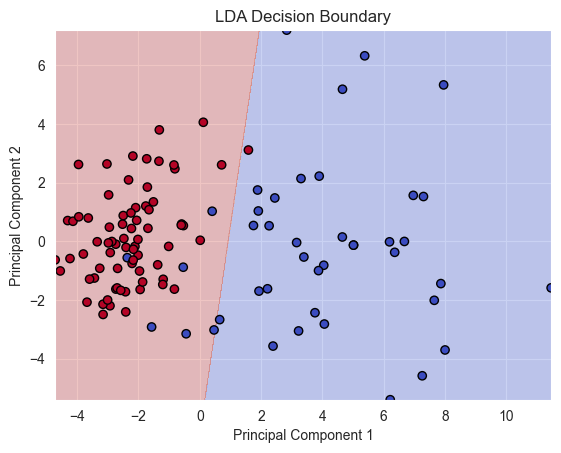

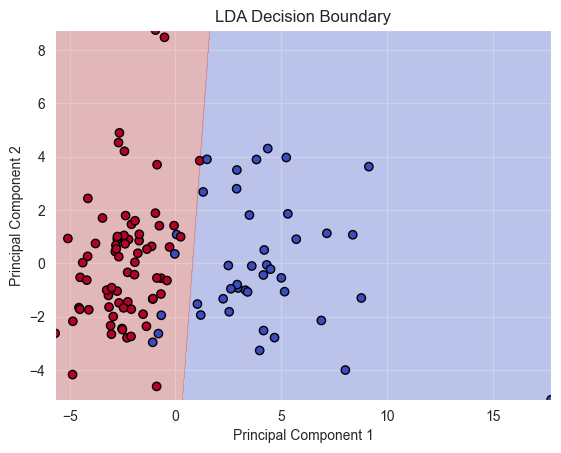

Precisión media de LDA: 0.9649
Desviación estándar de la precisión: 0.0055
Precisión media: 0.9518
Recall medio: 0.9944
F1-score medio: 0.9726
Matriz de confusión acumulada:
[[194  18]
 [  2 355]]


In [38]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Lista para almacenar las métricas
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
confusion_matrices = []

# Evaluar cada modelo en sus respectivos conjuntos de prueba
for model, test_index in trained_models:
    # Obtener los datos de prueba correspondientes
    X_test = X_scaled[test_index]
    y_test = y[test_index]

    # Hacer predicciones
    y_pred = model.predict(X_test)

    # Calcular las métricas y almacenarlas
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    confusion_matrices.append(confusion_matrix(y_test, y_pred))

    # Visualización de fronteras de decisión
    pca = PCA(n_components=2)
    X_test_pca = pca.fit_transform(X_test)
    xx, yy = np.meshgrid(np.linspace(X_test_pca[:, 0].min(), X_test_pca[:, 0].max(), 1000),
                         np.linspace(X_test_pca[:, 1].min(), X_test_pca[:, 1].max(), 1000))
    Z = model.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, edgecolor='k', cmap='coolwarm')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('LDA Decision Boundary')
    plt.show()

# Mostrar las métricas
print(f'Precisión media de LDA: {np.mean(accuracy_scores):.4f}')
print(f'Desviación estándar de la precisión: {np.std(accuracy_scores):.4f}')
print(f'Precisión media: {np.mean(precision_scores):.4f}')
print(f'Recall medio: {np.mean(recall_scores):.4f}')
print(f'F1-score medio: {np.mean(f1_scores):.4f}')
print(f'Matriz de confusión acumulada:\n{np.sum(confusion_matrices, axis=0)}')

---
# Ajuste de hiperparámetros

In [44]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# Definir los hiperparámetros a probar
param_distributions = {
    'solver': ['svd', 'lsqr', 'eigen'],
    'shrinkage': uniform(0, 1),
    'tol': uniform(1e-5, 1e-3),
}

# Lista para almacenar los modelos entrenados
trained_models = []

# Entrenar el modelo en cada fold
for train_index, test_index in folds_indices:
    # Dividir los datos en entrenamiento y prueba usando los índices generados
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Definir el modelo LDA con Random Search
    random_search = RandomizedSearchCV(
        LinearDiscriminantAnalysis(),
        param_distributions,
        n_iter=100,
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        random_state=42
    )

    # Entrenar el modelo LDA con Random Search
    random_search.fit(X_train, y_train)

    # Almacenar el mejor modelo entrenado
    trained_models.append((random_search.best_estimator_, test_index))

    # Imprimir los mejores parámetros para cada fold
    print(f"Mejores parámetros para el fold: {random_search.best_params_}")
    print(f"Mejor precisión para el fold: {random_search.best_score_:.4f}")

/Users/lucas/facultad/inteligencia_artificial/ia_venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
185 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
185 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/lucas/facultad/inteligencia_artificial/ia_venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/lucas/facultad/inteligencia_artificial/ia_venv/lib/python3.11/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Mejores parámetros para el fold: {'shrinkage': np.float64(0.005522117123602399), 'solver': 'eigen', 'tol': np.float64(0.00020884240408880516)}
Mejor precisión para el fold: 0.9648


/Users/lucas/facultad/inteligencia_artificial/ia_venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
185 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
185 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/lucas/facultad/inteligencia_artificial/ia_venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/lucas/facultad/inteligencia_artificial/ia_venv/lib/python3.11/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Mejores parámetros para el fold: {'shrinkage': np.float64(0.1195942459383017), 'solver': 'lsqr', 'tol': np.float64(0.0008589138242660839)}
Mejor precisión para el fold: 0.9582


/Users/lucas/facultad/inteligencia_artificial/ia_venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
185 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
185 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/lucas/facultad/inteligencia_artificial/ia_venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/lucas/facultad/inteligencia_artificial/ia_venv/lib/python3.11/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Mejores parámetros para el fold: {'shrinkage': np.float64(0.07404465173409036), 'solver': 'eigen', 'tol': np.float64(0.0006610770255019445)}
Mejor precisión para el fold: 0.9604
Mejores parámetros para el fold: {'shrinkage': np.float64(0.0884925020519195), 'solver': 'eigen', 'tol': np.float64(0.0005308342600258237)}
Mejor precisión para el fold: 0.9626
Mejores parámetros para el fold: {'shrinkage': np.float64(0.15599452033620265), 'solver': 'eigen', 'tol': np.float64(0.0004692488919658672)}
Mejor precisión para el fold: 0.9539


/Users/lucas/facultad/inteligencia_artificial/ia_venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
185 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
185 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/lucas/facultad/inteligencia_artificial/ia_venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/lucas/facultad/inteligencia_artificial/ia_venv/lib/python3.11/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^